
QUARTERLY REVENUE FORECASTING WITH SARIMA
EXTRACTING QUARTERLY DATA FROM EXCEL
File: Richspread.xlsx
Sheet: Quarterly Rev Step
Date Range: B2:AA2
Revenue Range: B4:AA4

Extracted 26 date entries
Extracted 26 revenue entries

Successfully processed quarterly data:
Date range: 2019-03-31 to 2025-06-30
Total quarters: 26
Revenue range: $6,623,185,000 to $10,435,979,000
Average quarterly revenue: $8,844,454,962
Data prepared: 18 training samples, 8 test samples
Quarterly frequency confirmed: Q

Analyzing seasonality in the data...

 SEASONALITY ANALYSIS 


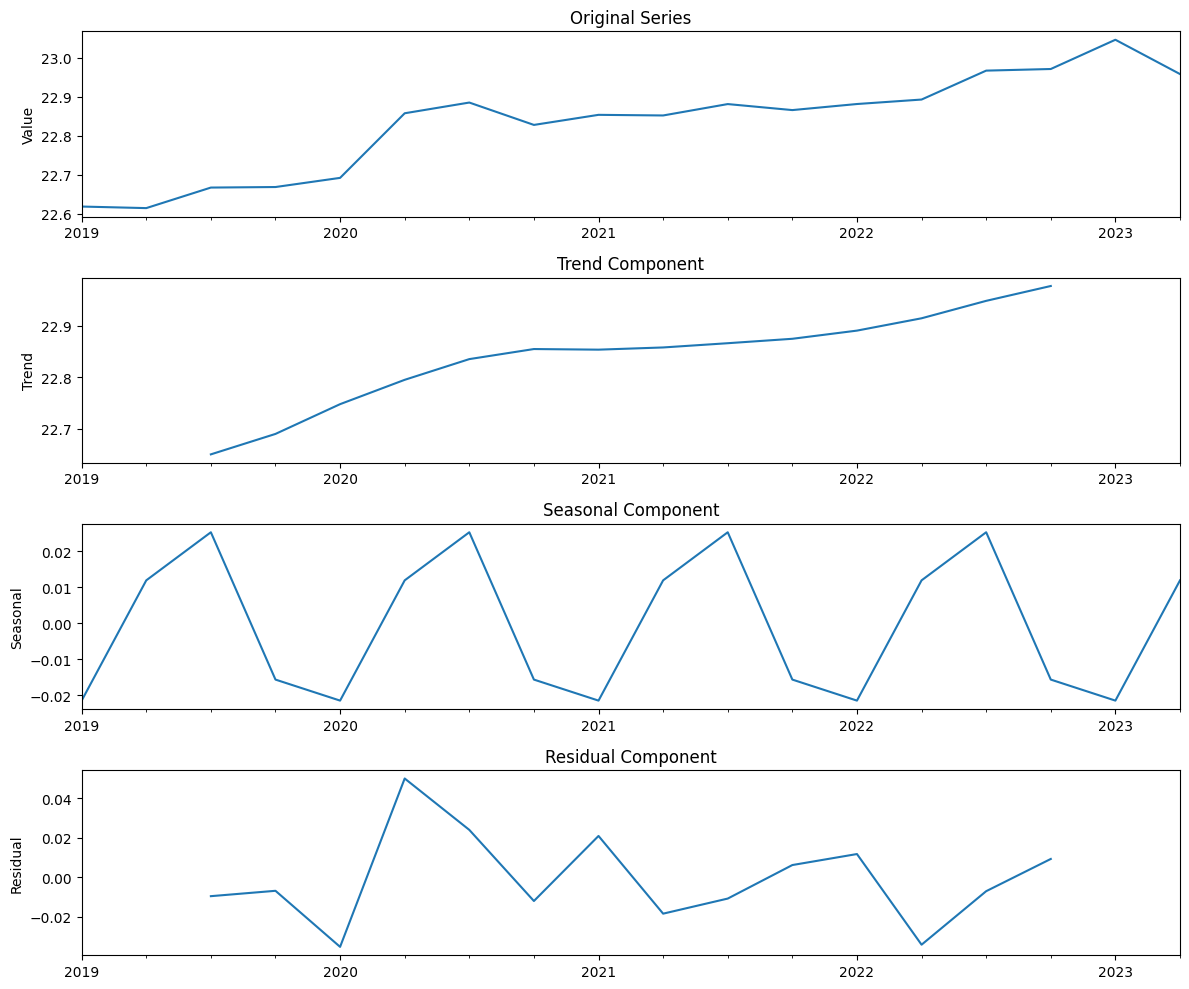

Seasonal Strength: 0.435
Interpretation: Moderate seasonality

Checking stationarity of the data...

=== STATIONARITY TESTS ===

Augmented Dickey-Fuller Test:
  ADF Statistic: -1.825950
  p-value: 0.367656
  Critical Values:
    1%: -4.332
    5%: -3.233
    10%: -2.749
  Result: Series is non-stationary (ADF test)

KPSS Test:
  KPSS Statistic: 0.634782
  p-value: 0.019474
  Critical Values:
    10%: 0.347
    5%: 0.463
    2.5%: 0.574
    1%: 0.739
  Result: Series is non-stationary (KPSS test)

Overall Assessment: Non-stationary

Plotting diagnostic charts...


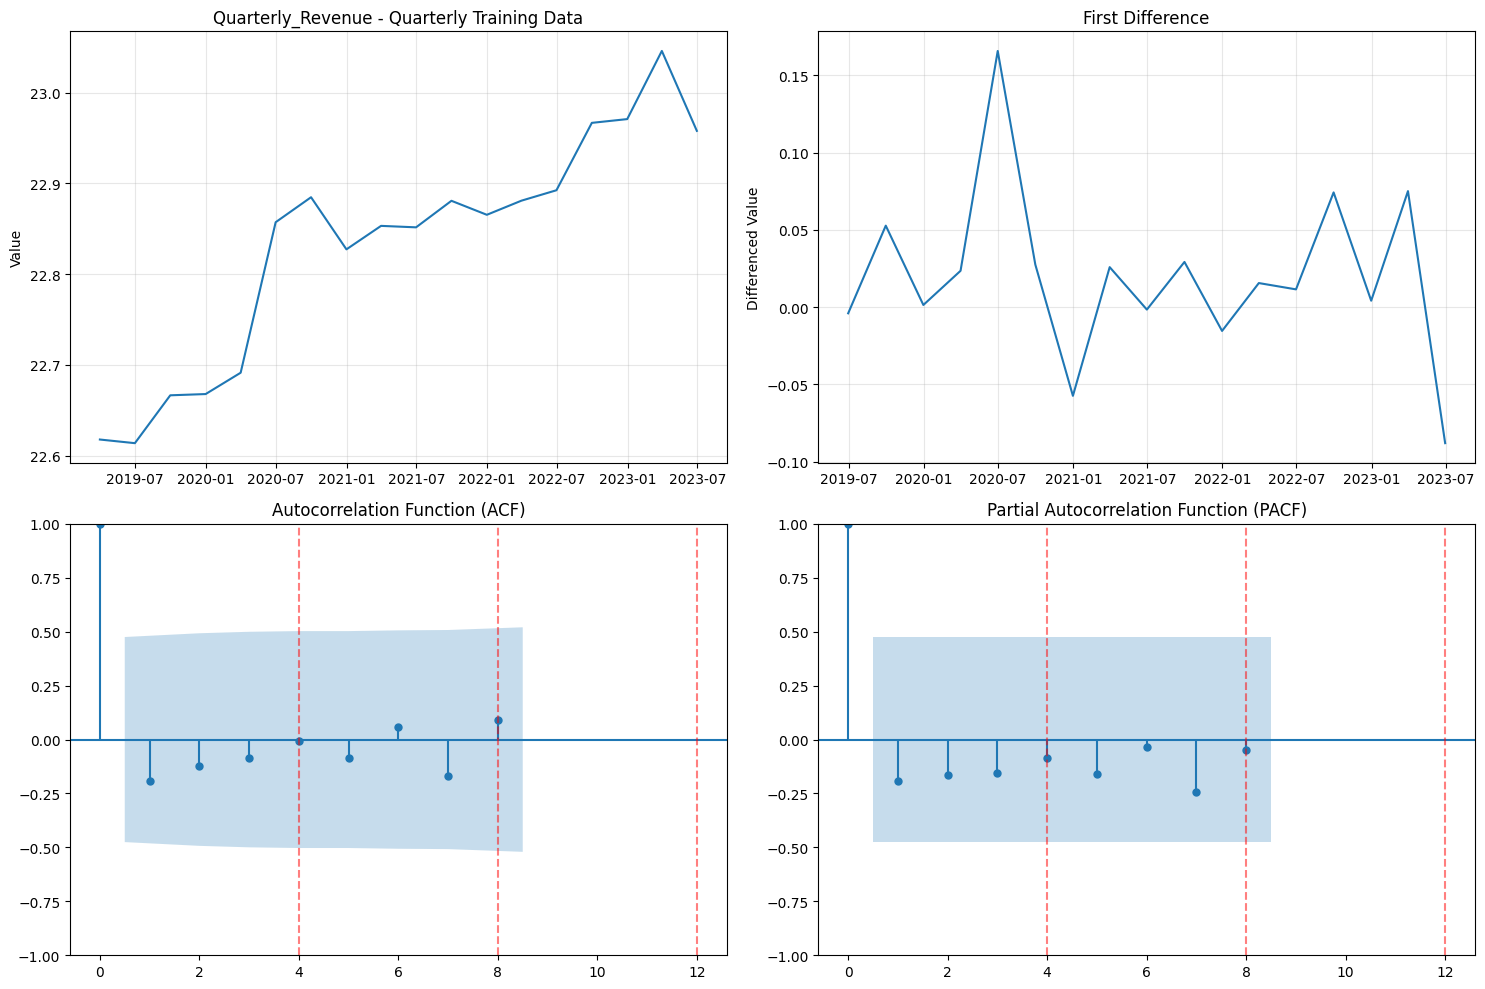


Searching for optimal SARIMA parameters...

=== SARIMA PARAMETER GRID SEARCH ===
Searching for optimal parameters...
Progress: 20/144 combinations tested
Progress: 40/144 combinations tested
Progress: 60/144 combinations tested
Progress: 80/144 combinations tested
Progress: 100/144 combinations tested
Progress: 120/144 combinations tested
Progress: 140/144 combinations tested
Progress: 144/144 combinations tested

Best SARIMA order: (1, 0, 0)x(0, 0, 0, 4)
Best AIC: -47.1137

Top 5 models by AIC:
  (1, 0, 0)x(0, 0, 0, 4) - AIC: -47.11
  (0, 1, 0)x(0, 0, 0, 4) - AIC: -43.09
  (1, 0, 1)x(0, 0, 0, 4) - AIC: -42.41
  (2, 0, 0)x(0, 0, 0, 4) - AIC: -42.19
  (1, 1, 0)x(0, 0, 0, 4) - AIC: -41.09

Generating forecasts for test period...

Evaluating model performance...

=== MODEL EVALUATION METRICS ===
MAPE: 2.48%
RMSE: 304695315.1305
MAE: 252379099.6400
Directional Accuracy: 71.4%

Plotting results...


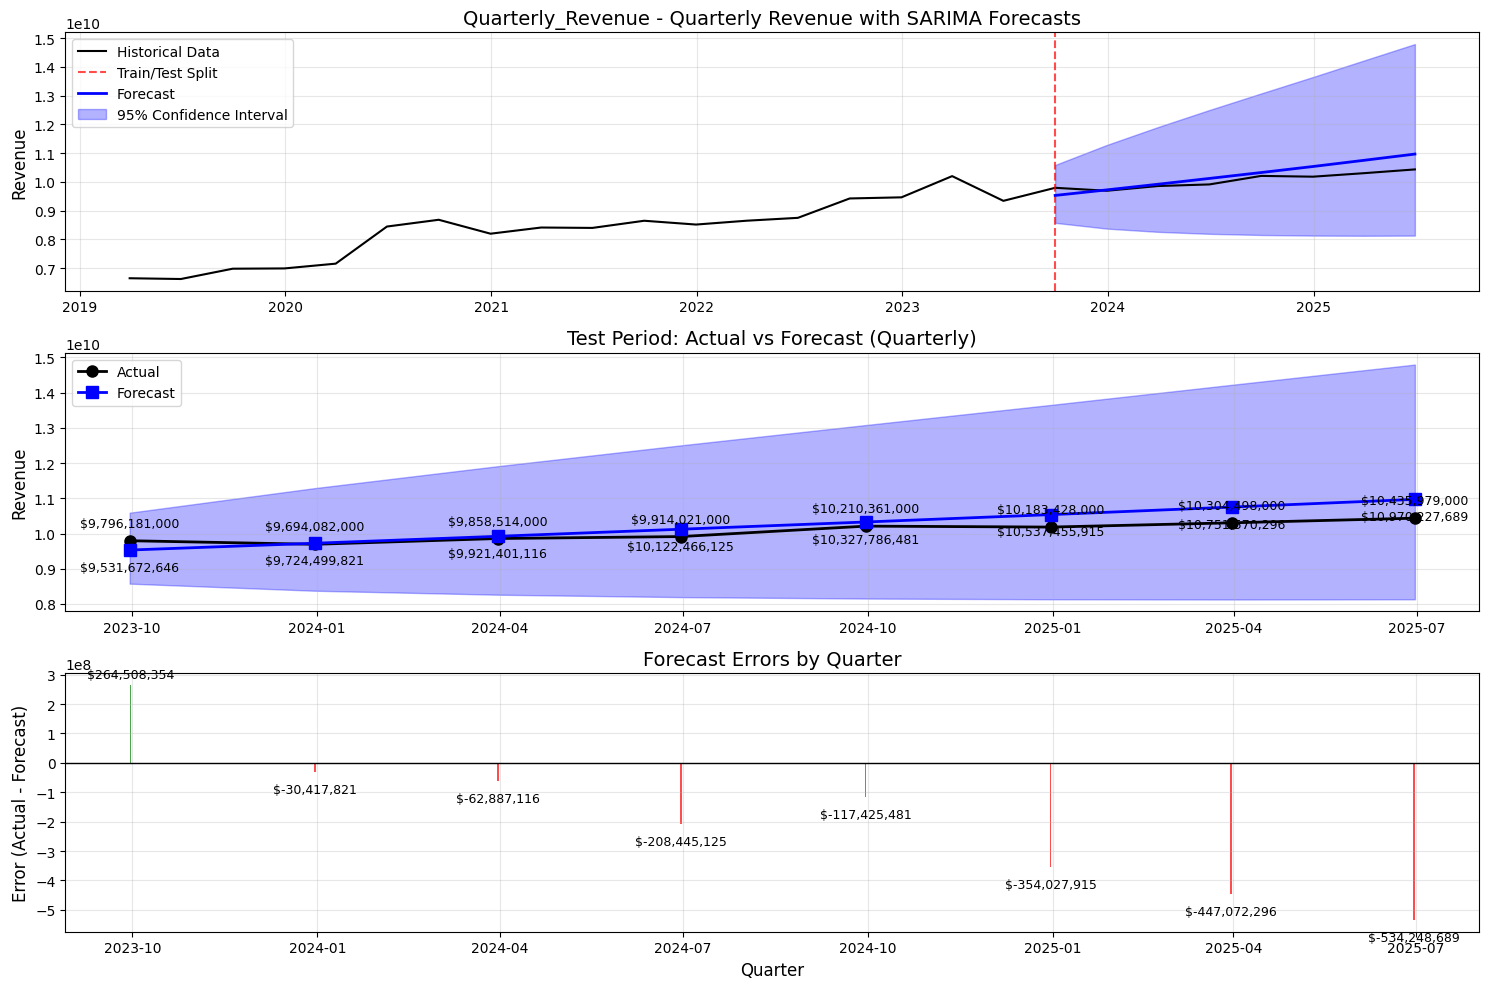


Generating residual diagnostic plots...

Generating residual diagnostic plots for SARIMA(1, 0, 0)x(0, 0, 0, 4) model...


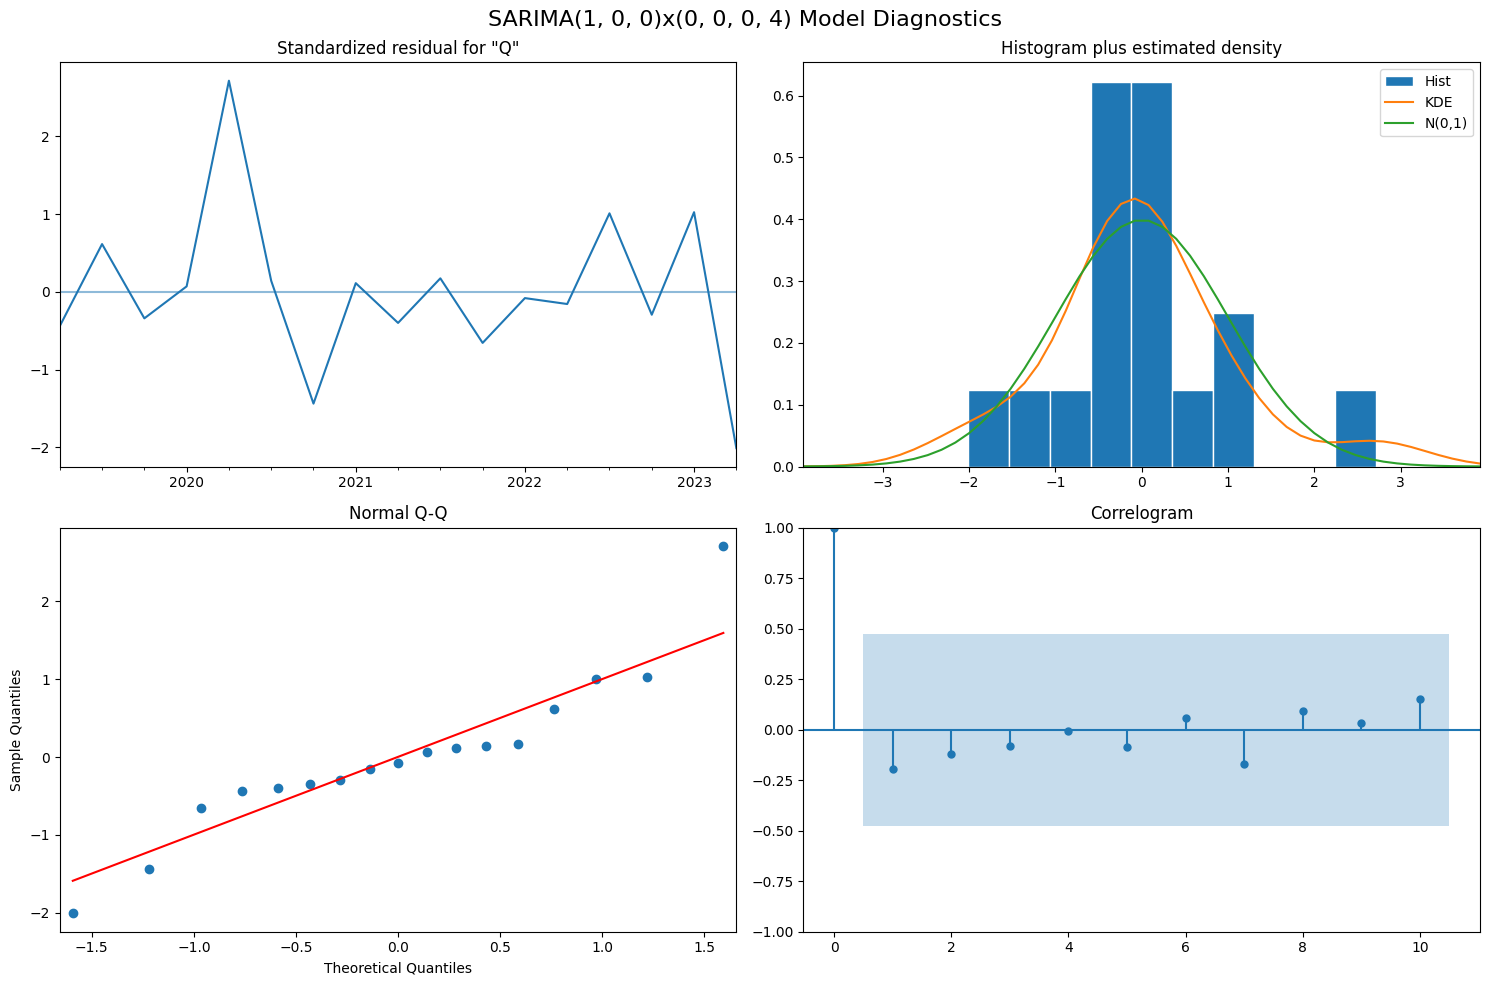


=== SARIMA(1, 0, 0)x(0, 0, 0, 4) MODEL SUMMARY ===
                               SARIMAX Results                                
Dep. Variable:      Quarterly_Revenue   No. Observations:                   18
Model:               SARIMAX(1, 0, 0)   Log Likelihood                  25.557
Date:                Mon, 28 Jul 2025   AIC                            -47.114
Time:                        13:20:07   BIC                            -45.447
Sample:                    03-31-2019   HQIC                           -46.948
                         - 06-30-2023                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.0009      0.001   1653.932      0.000       1.000       1.002
sigma2         0.0029      0.001      3.669      0.000       0.001       0.004


In [23]:
import xlwings as xw
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.stattools import adfuller, kpss
from statsmodels.tsa.seasonal import seasonal_decompose
import statsmodels.api as sm
from statsmodels.stats.diagnostic import acorr_ljungbox, het_breuschpagan
from scipy import stats
from scipy.stats import shapiro, probplot
from sklearn.metrics import mean_absolute_percentage_error, mean_squared_error
from typing import Optional, Tuple, Dict, List
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

# USER INPUTS 
EXCEL_FILE_PATH = 'Richspread.xlsx'           
SHEET_NAME = 'Quarterly Rev Step'            
DATE_RANGE = 'B2:AA2'                          
REVENUE_RANGE = 'B4:AA4'                      
START_DATE = None                          

# Forecasting Parameters
TEST_PERIODS = 8                              
FUTURE_FORECAST_PERIODS = 12                
AUTO_SELECT_PARAMETERS = True               
APPLY_LOG_TRANSFORMATION = True               

# SARIMA Parameters (if not auto-selecting)
SARIMA_ORDER = (1, 1, 1)                     
SEASONAL_ORDER = (1, 1, 1, 4)              

DATE_FORMAT = '%d/%m/%Y'                      # DD/MM/YYYY format

class SARIMAForecaster:
    """
    A reusable SARIMA model class for quarterly time series forecasting.
    """
    def __init__(self, data: pd.Series, target_column: str = None, frequency: str = 'Q'):
        if isinstance(data, pd.DataFrame):
            if target_column is None:
                raise ValueError("target_column must be specified for DataFrame input")
            self.data = data[target_column].copy()
            self.target_column = target_column
        else:
            self.data = data.copy()
            self.target_column = data.name or 'target'
        
        self.frequency = frequency
        self.original_data = self.data.copy()
        self.model = None
        self.best_order = None
        self.best_seasonal_order = None
        self.train_data = None
        self.test_data = None
        self.predictions = None
        self.forecast_results = None
        self.log_transformed = False
        self.seasonal_periods = 4  # Quarterly seasonality

    def prepare_data(self, start_date: str = None, end_date: str = None, 
                    test_size: int = 4, apply_log: bool = True):
        """
        Prepare data for SARIMA modeling
        """
        # Filter data by date range if specified
        if start_date or end_date:
            self.data = self.data.loc[start_date:end_date]
        
        # Remove any NaN values
        self.data = self.data.dropna()
        
        # Handle test_size being larger than available data
        if test_size >= len(self.data):
            test_size = max(1, len(self.data) // 4)
            print(f"Warning: test_size adjusted to {test_size} (25% of available data)")
        
        # Split into train and test sets
        if test_size == 0:
            self.train_data = self.data.copy()
            self.test_data = pd.Series(dtype=float)
        else:
            self.train_data = self.data.iloc[:-test_size].copy()
            self.test_data = self.data.iloc[-test_size:].copy()
        
        # Apply log transformation if specified
        if apply_log and len(self.train_data) > 0:
            self.train_data = np.log(self.train_data + 1e-8)
            self.log_transformed = True
        else:
            self.log_transformed = False
        
        print(f"Data prepared: {len(self.train_data)} training samples, {len(self.test_data)} test samples")
        print(f"Quarterly frequency confirmed: {self.frequency}")
        return self

    def check_seasonality(self, series: pd.Series = None, lags: int = 20):
        """
        Check for seasonality in the data
        """
        if series is None:
            series = self.train_data
        
        if len(series) < 8: 
            print("Warning: Not enough data points for seasonality test")
            return None
        
        print("\n SEASONALITY ANALYSIS ")
        
        # Decompose the time series
        try:
            decomposition = seasonal_decompose(series, model='additive', period=self.seasonal_periods)
            
            fig, axes = plt.subplots(4, 1, figsize=(12, 10))
            
            series.plot(ax=axes[0], title='Original Series')
            axes[0].set_ylabel('Value')
            
            decomposition.trend.plot(ax=axes[1], title='Trend Component')
            axes[1].set_ylabel('Trend')
            
            decomposition.seasonal.plot(ax=axes[2], title='Seasonal Component')
            axes[2].set_ylabel('Seasonal')
            
            decomposition.resid.plot(ax=axes[3], title='Residual Component')
            axes[3].set_ylabel('Residual')
            
            plt.tight_layout()
            plt.show()
            
            # Calculate strength of seasonality
            seasonal_strength = 1 - (decomposition.resid.var() / 
                                   (decomposition.resid + decomposition.seasonal).var())
            print(f"Seasonal Strength: {seasonal_strength:.3f}")
            print(f"Interpretation: {'Strong' if seasonal_strength > 0.64 else 'Moderate' if seasonal_strength > 0.3 else 'Weak'} seasonality")
            
            return decomposition
        except Exception as e:
            print(f"Error in seasonal decomposition: {e}")
            return None

    def check_stationarity(self, series: pd.Series = None, alpha: float = 0.05) -> Dict:
        """
        Enhanced stationarity check with both ADF and KPSS tests
        """
        if series is None:
            series = self.train_data
        
        if len(series.dropna()) < 3:
            print("Warning: Not enough data points for stationarity test")
            return {'stationary': False}
        
        print("\n=== STATIONARITY TESTS ===")
        
        # ADF Test
        adf_result = adfuller(series.dropna())
        print(f'\nAugmented Dickey-Fuller Test:')
        print(f'  ADF Statistic: {adf_result[0]:.6f}')
        print(f'  p-value: {adf_result[1]:.6f}')
        print('  Critical Values:')
        for key, value in adf_result[4].items():
            print(f'    {key}: {value:.3f}')
        
        adf_stationary = adf_result[1] <= alpha
        print(f'  Result: Series is {"stationary" if adf_stationary else "non-stationary"} (ADF test)')
        
        # KPSS Test
        try:
            kpss_result = kpss(series.dropna(), regression='c')
            print(f'\nKPSS Test:')
            print(f'  KPSS Statistic: {kpss_result[0]:.6f}')
            print(f'  p-value: {kpss_result[1]:.6f}')
            print('  Critical Values:')
            for key, value in kpss_result[3].items():
                print(f'    {key}: {value:.3f}')
            
            kpss_stationary = kpss_result[1] > alpha
            print(f'  Result: Series is {"stationary" if kpss_stationary else "non-stationary"} (KPSS test)')
        except:
            kpss_stationary = None
            print("  KPSS test failed")
        
        # Combined interpretation
        if adf_stationary and (kpss_stationary is None or kpss_stationary):
            overall_result = "Stationary"
        elif not adf_stationary and (kpss_stationary is None or not kpss_stationary):
            overall_result = "Non-stationary"
        else:
            overall_result = "Difference stationary (trend stationary)"
        
        print(f'\nOverall Assessment: {overall_result}')
        
        return {
            'stationary': adf_stationary,
            'adf_pvalue': adf_result[1],
            'kpss_pvalue': kpss_result[1] if kpss_stationary is not None else None,
            'overall': overall_result
        }

    def plot_diagnostics(self, series: pd.Series = None, lags: int = 20):
        """
        Plot diagnostic charts for quarterly data
        """
        if series is None:
            series = self.train_data.dropna()
        
        max_lags = min(lags, len(series) // 2 - 1)
        if max_lags < 1:
            print("Warning: Not enough data for diagnostic plots")
            return None
        
        fig, axes = plt.subplots(2, 2, figsize=(15, 10))
        
        # Time series plot
        axes[0, 0].plot(series)
        axes[0, 0].set_title(f'{self.target_column} - Quarterly Training Data')
        axes[0, 0].set_ylabel('Value')
        axes[0, 0].grid(True, alpha=0.3)
        
        # First difference
        diff_series = series.diff().dropna()
        if len(diff_series) > 0:
            axes[0, 1].plot(diff_series)
            axes[0, 1].set_title('First Difference')
            axes[0, 1].set_ylabel('Differenced Value')
            axes[0, 1].grid(True, alpha=0.3)
            
            # ACF
            try:
                sm.graphics.tsa.plot_acf(diff_series, lags=max_lags, ax=axes[1, 0])
                axes[1, 0].set_title('Autocorrelation Function (ACF)')
                axes[1, 0].axvline(x=4, color='red', linestyle='--', alpha=0.5, label='Seasonal lag')
                axes[1, 0].axvline(x=8, color='red', linestyle='--', alpha=0.5)
                axes[1, 0].axvline(x=12, color='red', linestyle='--', alpha=0.5)
            except:
                axes[1, 0].text(0.5, 0.5, 'ACF plot failed', ha='center', va='center')
            
            # PACF
            try:
                sm.graphics.tsa.plot_pacf(diff_series, lags=max_lags, ax=axes[1, 1])
                axes[1, 1].set_title('Partial Autocorrelation Function (PACF)')
                axes[1, 1].axvline(x=4, color='red', linestyle='--', alpha=0.5, label='Seasonal lag')
                axes[1, 1].axvline(x=8, color='red', linestyle='--', alpha=0.5)
                axes[1, 1].axvline(x=12, color='red', linestyle='--', alpha=0.5)
            except:
                axes[1, 1].text(0.5, 0.5, 'PACF plot failed', ha='center', va='center')
        
        plt.tight_layout()
        plt.show()
        return fig

    def grid_search(self, max_p: int = 2, max_d: int = 1, max_q: int = 2,
                   max_P: int = 2, max_D: int = 1, max_Q: int = 2) -> Dict:
        """
        Grid search for optimal SARIMA parameters
        """
        print("\n=== SARIMA PARAMETER GRID SEARCH ===")
        print("Searching for optimal parameters...")
        
        data_len = len(self.train_data)
        
        # Adjust maximum values based on data length
        max_p = min(max_p, max(1, data_len // 8))
        max_q = min(max_q, max(1, data_len // 8))
        max_P = min(max_P, max(1, data_len // 12))
        max_Q = min(max_Q, max(1, data_len // 12))
        
        p_range = range(0, max_p + 1)
        d_range = range(0, max_d + 1)
        q_range = range(0, max_q + 1)
        P_range = range(0, max_P + 1)
        D_range = range(0, max_D + 1)
        Q_range = range(0, max_Q + 1)
        
        best_aic = np.inf
        best_order = None
        best_seasonal_order = None
        best_model = None
        results_list = []
        
        total_combinations = (len(p_range) * len(d_range) * len(q_range) * 
                            len(P_range) * len(D_range) * len(Q_range))
        current_combination = 0
        
        for p in p_range:
            for d in d_range:
                for q in q_range:
                    for P in P_range:
                        for D in D_range:
                            for Q in Q_range:
                                current_combination += 1
                                order = (p, d, q)
                                seasonal_order = (P, D, Q, self.seasonal_periods)
                                
                                try:
                                    model = SARIMAX(self.train_data, 
                                                  order=order,
                                                  seasonal_order=seasonal_order,
                                                  enforce_stationarity=False,
                                                  enforce_invertibility=False)
                                    fitted_model = model.fit(disp=False)
                                    aic = fitted_model.aic
                                    
                                    results_list.append({
                                        'order': order,
                                        'seasonal_order': seasonal_order,
                                        'aic': aic,
                                        'bic': fitted_model.bic,
                                        'hqic': fitted_model.hqic
                                    })
                                    
                                    if aic < best_aic:
                                        best_aic = aic
                                        best_order = order
                                        best_seasonal_order = seasonal_order
                                        best_model = fitted_model
                                        
                                except Exception as e:
                                    results_list.append({
                                        'order': order,
                                        'seasonal_order': seasonal_order,
                                        'aic': np.nan,
                                        'bic': np.nan,
                                        'hqic': np.nan,
                                        'error': str(e)
                                    })
                                    continue
                                
                                if current_combination % 20 == 0 or current_combination == total_combinations:
                                    print(f"Progress: {current_combination}/{total_combinations} combinations tested")
        
        if best_order is None:
            print("Warning: No valid SARIMA model found. Using default parameters")
            best_order = (1, 1, 1)
            best_seasonal_order = (1, 1, 1, self.seasonal_periods)
            best_model = SARIMAX(self.train_data, 
                               order=best_order,
                               seasonal_order=best_seasonal_order).fit(disp=False)
            best_aic = best_model.aic
        
        self.best_order = best_order
        self.best_seasonal_order = best_seasonal_order
        self.model = best_model
        
        print(f"\nBest SARIMA order: {best_order}x{best_seasonal_order}")
        print(f"Best AIC: {best_aic:.4f}")
        
        # Show top 5 models
        results_df = pd.DataFrame(results_list)
        valid_results = results_df.dropna(subset=['aic']).sort_values('aic').head(5)
        print("\nTop 5 models by AIC:")
        for idx, row in valid_results.iterrows():
            print(f"  {row['order']}x{row['seasonal_order']} - AIC: {row['aic']:.2f}")
        
        return {
            'best_order': best_order,
            'best_seasonal_order': best_seasonal_order,
            'best_aic': best_aic,
            'best_model': best_model,
            'all_results': results_df
        }

    def fit_model(self, order: Tuple[int, int, int] = None, 
                 seasonal_order: Tuple[int, int, int, int] = None):
        """
        Fit SARIMA model with specified parameters
        """
        if order is None:
            if self.best_order is None:
                order = SARIMA_ORDER
            else:
                order = self.best_order
        
        if seasonal_order is None:
            if self.best_seasonal_order is None:
                seasonal_order = SEASONAL_ORDER
            else:
                seasonal_order = self.best_seasonal_order
        
        print(f"\nFitting SARIMA{order}x{seasonal_order} model...")
        
        model = SARIMAX(self.train_data, 
                       order=order,
                       seasonal_order=seasonal_order,
                       enforce_stationarity=False,
                       enforce_invertibility=False)
        
        self.model = model.fit(disp=False)
        self.best_order = order
        self.best_seasonal_order = seasonal_order
        
        print("Model fitted successfully!")
        print(f"AIC: {self.model.aic:.4f}")
        print(f"BIC: {self.model.bic:.4f}")
        
        return self

    def forecast(self, periods: int = None) -> pd.DataFrame:
        """
        Generate forecasts for specified periods
        """
        if self.model is None:
            raise ValueError("Model not fitted. Run fit_model() first.")
        
        if periods is None:
            periods = len(self.test_data) if len(self.test_data) > 0 else 1
        
        # Get forecast
        forecast_result = self.model.get_forecast(steps=periods)
        forecast_df = forecast_result.summary_frame()
        
        # Reverse log transformation if applied
        if self.log_transformed:
            forecast_df = np.exp(forecast_df)
        
        # Rename columns for clarity
        forecast_df.columns = ['forecast', 'std_err', 'lower_ci', 'upper_ci']
        
        # Set proper index
        if self.test_data is not None and len(self.test_data) > 0:
            min_len = min(len(forecast_df), len(self.test_data))
            forecast_df = forecast_df.iloc[:min_len].copy()
            forecast_df.index = self.test_data.index[:min_len]
        
        self.forecast_results = forecast_df
        return forecast_df

    def evaluate_model(self) -> Dict:
        """
        Evaluate model performance on test data
        """
        if self.forecast_results is None:
            self.forecast()
        
        if len(self.test_data) == 0:
            print("Warning: No test data available for evaluation")
            return {'MAPE': np.nan, 'RMSE': np.nan, 'MAE': np.nan}
        
        actual = self.test_data.values
        predicted = self.forecast_results['forecast'].values
        
        # Calculate metrics
        mape = mean_absolute_percentage_error(actual, predicted) * 100
        rmse = np.sqrt(mean_squared_error(actual, predicted))
        mae = np.mean(np.abs(actual - predicted))
        
        # Calculate directional accuracy
        if len(actual) > 1:
            actual_direction = np.diff(actual) > 0
            predicted_direction = np.diff(predicted) > 0
            directional_accuracy = np.mean(actual_direction == predicted_direction) * 100
        else:
            directional_accuracy = np.nan
        
        metrics = {
            'MAPE': mape,
            'RMSE': rmse,
            'MAE': mae,
            'Directional_Accuracy': directional_accuracy,
            'Mean_Actual': np.mean(actual),
            'Mean_Predicted': np.mean(predicted)
        }
        
        print("\n=== MODEL EVALUATION METRICS ===")
        print(f"MAPE: {mape:.2f}%")
        print(f"RMSE: {rmse:.4f}")
        print(f"MAE: {mae:.4f}")
        if not np.isnan(directional_accuracy):
            print(f"Directional Accuracy: {directional_accuracy:.1f}%")
        
        return metrics

    def plot_results(self, figsize: Tuple[int, int] = (15, 10)):
        """
        Plot comprehensive results for quarterly data
        """
        if self.forecast_results is None:
            self.forecast()
        
        fig, axes = plt.subplots(3, 1, figsize=figsize)
        
        # 1. Full time series with forecasts
        axes[0].plot(self.original_data.index, self.original_data.values, 
                    label='Historical Data', color='black', linewidth=1.5)
        
        if len(self.test_data) > 0:
            split_date = self.test_data.index[0]
            axes[0].axvline(x=split_date, color='red', linestyle='--', 
                           alpha=0.7, label='Train/Test Split')
            
            # Plot forecast
            axes[0].plot(self.test_data.index[:len(self.forecast_results)], 
                        self.forecast_results['forecast'].values,
                        label='Forecast', color='blue', linewidth=2)
            
            # Confidence interval
            axes[0].fill_between(self.test_data.index[:len(self.forecast_results)],
                               self.forecast_results['lower_ci'].values,
                               self.forecast_results['upper_ci'].values,
                               alpha=0.3, color='blue', label='95% Confidence Interval')
        
        axes[0].set_title(f'{self.target_column} - Quarterly Revenue with SARIMA Forecasts', fontsize=14)
        axes[0].set_ylabel('Revenue', fontsize=12)
        axes[0].legend(loc='best')
        axes[0].grid(True, alpha=0.3)
        
        # 2. Test period close-up
        if len(self.test_data) > 0:
            test_idx = self.test_data.index[:len(self.forecast_results)]
            axes[1].plot(test_idx, self.test_data.values[:len(self.forecast_results)],
                        label='Actual', color='black', marker='o', markersize=8, linewidth=2)
            axes[1].plot(test_idx, self.forecast_results['forecast'].values,
                        label='Forecast', color='blue', marker='s', markersize=8, linewidth=2)
            axes[1].fill_between(test_idx,
                               self.forecast_results['lower_ci'].values,
                               self.forecast_results['upper_ci'].values,
                               alpha=0.3, color='blue')
            
            # Add value labels
            for i, (date, actual, forecast) in enumerate(zip(test_idx, 
                                                            self.test_data.values[:len(self.forecast_results)],
                                                            self.forecast_results['forecast'].values)):
                axes[1].annotate(f'${actual:,.0f}', (date, actual), 
                               textcoords="offset points", xytext=(0,10), ha='center', fontsize=9)
                axes[1].annotate(f'${forecast:,.0f}', (date, forecast), 
                               textcoords="offset points", xytext=(0,-15), ha='center', fontsize=9)
            
            axes[1].set_title('Test Period: Actual vs Forecast (Quarterly)', fontsize=14)
            axes[1].set_ylabel('Revenue', fontsize=12)
            axes[1].legend(loc='best')
            axes[1].grid(True, alpha=0.3)
        else:
            axes[1].text(0.5, 0.5, 'No test data available', ha='center', va='center', 
                        transform=axes[1].transAxes, fontsize=14)
            axes[1].set_title('Test Period: No Data Available')
        
        # 3. Forecast errors
        if len(self.test_data) > 0:
            errors = self.test_data.values[:len(self.forecast_results)] - self.forecast_results['forecast'].values
            axes[2].bar(test_idx, errors, color=['red' if e < 0 else 'green' for e in errors], alpha=0.7)
            axes[2].axhline(y=0, color='black', linestyle='-', linewidth=1)
            axes[2].set_title('Forecast Errors by Quarter', fontsize=14)
            axes[2].set_ylabel('Error (Actual - Forecast)', fontsize=12)
            axes[2].set_xlabel('Quarter', fontsize=12)
            axes[2].grid(True, alpha=0.3)
            
            
            for i, (date, error) in enumerate(zip(test_idx, errors)):
                axes[2].annotate(f'${error:,.0f}', (date, error), 
                               textcoords="offset points", xytext=(0,5 if error > 0 else -15), 
                               ha='center', fontsize=9)
        
        plt.tight_layout()
        plt.show()
        return fig

    def plot_residual_diagnostics(self, figsize: Tuple[int, int] = (15, 10)):
        """
        Plot residual diagnostics for SARIMA model
        """
        if self.model is None:
            raise ValueError("Model not fitted. Run fit_model() first.")
        
        print(f"\nGenerating residual diagnostic plots for SARIMA{self.best_order}x{self.best_seasonal_order} model...")
        
        try:
            fig = self.model.plot_diagnostics(figsize=figsize)
            plt.suptitle(f'SARIMA{self.best_order}x{self.best_seasonal_order} Model Diagnostics', fontsize=16)
            plt.tight_layout()
            plt.show()
            return fig
        except Exception as e:
            print(f"Error generating diagnostic plots: {e}")
            return None


    def get_model_summary(self):
        """
        Print model summary
        """
        if self.model is None:
            raise ValueError("Model not fitted. Run fit_model() first.")
        
        print(f"\n=== SARIMA{self.best_order}x{self.best_seasonal_order} MODEL SUMMARY ===")
        print(self.model.summary())

    def forecast_future(self, periods: int, return_confidence: bool = True) -> pd.DataFrame:
        """
        Forecast future periods beyond the available data
        """
        if self.model is None:
            raise ValueError("Model not fitted. Run fit_model() first.")
        
        # Get the last date from the training data (not original data)
        last_date = self.train_data.index[-1]
        
        # Generate future dates 
        future_dates = pd.date_range(start=last_date, periods=periods + 1, freq='Q')[1:]
        
        # Generate forecast
        forecast_result = self.model.get_forecast(steps=periods)
        forecast_df = forecast_result.summary_frame()
        
        # Reverse log transformation if applied
        if self.log_transformed:
            forecast_df = np.exp(forecast_df)
        
        # Set proper index and column names
        forecast_df.index = future_dates
        forecast_df.columns = ['forecast', 'std_err', 'lower_ci', 'upper_ci']
        
        if not return_confidence:
            return forecast_df[['forecast']]
        
        return forecast_df


def extract_quarterly_data_from_excel(file_path: str, sheet_name: str, 
                                    date_range: str, revenue_range: str, 
                                    date_format: str = '%d/%m/%Y') -> pd.Series:
    """
    Extract quarterly data from Excel file with proper error handling
    """
    print("="*60)
    print("EXTRACTING QUARTERLY DATA FROM EXCEL")
    print("="*60)
    print(f"File: {file_path}")
    print(f"Sheet: {sheet_name}")
    print(f"Date Range: {date_range}")
    print(f"Revenue Range: {revenue_range}")
    
    try:
        
        book = xw.Book(file_path)
        sheet = book.sheets[sheet_name]
        
        # Extract data
        dates_raw = sheet.range(date_range).value
        revenue_raw = sheet.range(revenue_range).value
        
        print(f"\nExtracted {len(dates_raw) if isinstance(dates_raw, list) else 1} date entries")
        print(f"Extracted {len(revenue_raw) if isinstance(revenue_raw, list) else 1} revenue entries")
        
        # Ensure lists
        if not isinstance(dates_raw, list):
            dates_raw = [dates_raw]
        if not isinstance(revenue_raw, list):
            revenue_raw = [revenue_raw]
        
        
        processed_dates = []
        processed_revenue = []
        
        for i, (date_val, rev_val) in enumerate(zip(dates_raw, revenue_raw)):
            if date_val is not None and rev_val is not None:
                try:
                    # Handle date conversion
                    if isinstance(date_val, datetime):
                        processed_date = date_val
                    elif isinstance(date_val, str):
                        processed_date = datetime.strptime(date_val, date_format)
                    else:
                        print(f"Warning: Skipping entry {i+1} - Unknown date format: {type(date_val)}")
                        continue
                    
                    # Convert revenue to float
                    processed_revenue_val = float(rev_val)
                    
                    processed_dates.append(processed_date)
                    processed_revenue.append(processed_revenue_val)
                    
                except (ValueError, TypeError) as e:
                    print(f"Warning: Skipping entry {i+1} - Error processing data: {e}")
                    continue
        
        # Create pandas Series
        revenue_series = pd.Series(
    data=processed_revenue,
    index=pd.to_datetime(processed_dates),
    name='Quarterly_Revenue'
)

# Convert to quarter periods and then to quarter-end timestamps
        revenue_series.index = revenue_series.index.to_period('Q').to_timestamp('Q')

# Sort by date
        revenue_series = revenue_series.sort_index()


        revenue_series = revenue_series[~revenue_series.index.duplicated(keep='first')]
        
        print(f"\nSuccessfully processed quarterly data:")
        
        
        valid_dates = revenue_series.index.dropna()
        if len(valid_dates) > 0:
            print(f"Date range: {valid_dates.min().strftime('%Y-%m-%d')} to {valid_dates.max().strftime('%Y-%m-%d')}")
        else:
            print("Warning: No valid dates found in the data")
        
        print(f"Total quarters: {len(revenue_series)}")
        print(f"Revenue range: ${revenue_series.min():,.0f} to ${revenue_series.max():,.0f}")
        print(f"Average quarterly revenue: ${revenue_series.mean():,.0f}")
        
        
        if len(valid_dates) > 1:
            expected_quarters = pd.date_range(start=valid_dates.min(), 
                                            end=valid_dates.max(), 
                                            freq='Q')
            missing_quarters = expected_quarters.difference(revenue_series.index)
            if len(missing_quarters) > 0:
                print(f"\nWarning: {len(missing_quarters)} missing quarters detected")
        
        return revenue_series
        
    except Exception as e:
        print(f"Error extracting data from Excel: {e}")
        print("Please check your file path, sheet name, and cell ranges.")
        raise

def run_quarterly_revenue_forecast():
    """
    Main function to run quarterly revenue forecasting with SARIMA
    """
    print("\n" + "="*80)
    print("QUARTERLY REVENUE FORECASTING WITH SARIMA")
    print("="*80)
    
    try:
        # Extract quarterly data
        revenue_series = extract_quarterly_data_from_excel(
            file_path=EXCEL_FILE_PATH,
            sheet_name=SHEET_NAME,
            date_range=DATE_RANGE,
            revenue_range=REVENUE_RANGE,
            date_format=DATE_FORMAT
        )
        
        # Create forecaster instance
        forecaster = SARIMAForecaster(revenue_series, frequency='Q')
        
        # Prepare data
        forecaster.prepare_data(
            start_date=START_DATE,
            test_size=TEST_PERIODS,
            apply_log=APPLY_LOG_TRANSFORMATION
        )
        
        # Check seasonality
        print("\nAnalyzing seasonality in the data...")
        forecaster.check_seasonality()
        
        # Check stationarity
        print("\nChecking stationarity of the data...")
        stationarity_result = forecaster.check_stationarity()
        
        # Plot diagnostics
        print("\nPlotting diagnostic charts...")
        forecaster.plot_diagnostics()
        
        # Find optimal parameters or use specified ones
        if AUTO_SELECT_PARAMETERS:
            print("\nSearching for optimal SARIMA parameters...")
            forecaster.grid_search(max_p=2, max_d=1, max_q=2, 
                                 max_P=2, max_D=1, max_Q=2)
        else:
            print("\nUsing specified SARIMA parameters...")
            forecaster.fit_model(order=SARIMA_ORDER, seasonal_order=SEASONAL_ORDER)
        
        # Generate forecasts for test period
        print("\nGenerating forecasts for test period...")
        forecaster.forecast()
        
        # Evaluate model
        print("\nEvaluating model performance...")
        metrics = forecaster.evaluate_model()
        
        # Plot results
        print("\nPlotting results...")
        forecaster.plot_results()
        
        # Plot residual diagnostics
        print("\nGenerating residual diagnostic plots...")
        forecaster.plot_residual_diagnostics()
        
        
        forecaster.get_model_summary()
        
        # Future forecasting
        print("\n" + "="*60)
        print("FUTURE QUARTERLY REVENUE FORECASTING")
        print("="*60)
        
        # Create new forecaster with all data for future predictions
        future_forecaster = SARIMAForecaster(revenue_series, frequency='Q')
        future_forecaster.prepare_data(start_date=START_DATE, test_size=0, 
                                     apply_log=APPLY_LOG_TRANSFORMATION)
        future_forecaster.fit_model(order=forecaster.best_order, 
                                  seasonal_order=forecaster.best_seasonal_order)
        
        # Generate future forecasts
        future_forecast = future_forecaster.forecast_future(periods=FUTURE_FORECAST_PERIODS)
        
        print(f"\nFuture Quarterly Revenue Predictions ({FUTURE_FORECAST_PERIODS} quarters ahead):")
        print("-" * 70)
        print(f"{'Quarter':<20} {'Forecast':<15} {'Lower CI':<15} {'Upper CI':<15}")
        print("-" * 70)
        
        for date, row in future_forecast.iterrows():
            quarter_str = f"Q{date.quarter} {date.year}"
            print(f"{quarter_str:<20} ${row['forecast']:>12,.0f} ${row['lower_ci']:>12,.0f} ${row['upper_ci']:>12,.0f}")
        
        # Calculate growth metrics
        last_actual = revenue_series.iloc[-1]
        last_forecast = future_forecast['forecast'].iloc[-1]
        total_growth = (last_forecast - last_actual) / last_actual * 100
        
        quarters_ahead = FUTURE_FORECAST_PERIODS
        years_ahead = quarters_ahead / 4
        annual_growth = (np.power(last_forecast / last_actual, 1 / years_ahead) - 1) * 100
        
        print(f"\nGrowth Projections:")
        print(f"Total growth over {quarters_ahead} quarters: {total_growth:.1f}%")
        print(f"Implied annual growth rate: {annual_growth:.1f}%")
        
        # Summary
        print("\n" + "="*60)
        print("ANALYSIS SUMMARY")
        print("="*60)
        print(f"Best SARIMA Model: {forecaster.best_order}x{forecaster.best_seasonal_order}")
        print(f"Model Performance (MAPE): {metrics['MAPE']:.2f}%")
        print(f"Historical Quarters: {len(revenue_series)}")
        print(f"Test Quarters: {TEST_PERIODS}")
        print(f"Future Forecast Quarters: {FUTURE_FORECAST_PERIODS}")
        print(f"Seasonality Pattern: Quarterly (s=4)")
        
        return forecaster, future_forecast, metrics
        
    except Exception as e:
        print(f"\nError in forecasting pipeline: {e}")
        import traceback
        traceback.print_exc()
        return None, None, None

if __name__ == "__main__":
    forecaster, future_forecast, metrics = run_quarterly_revenue_forecast()
    
    revenue_series = forecaster.original_data if forecaster is not None else None